In [1]:
import os

import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        return [0 for _ in observations], [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass

    def learn_on_batch(self, samples):
        return {}


no_action = rllib.agents.trainer_template.build_trainer(name="NoAction", default_policy=NoAction)

In [4]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:
    # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

# ALTERNATIVE: use the "Ray client" to connect to a remote cluster
# Unfortunately, JupyterNotebookReporter displays an object reference
# <IPython.core.display.HTML object> instead of content...
# --- --- ---
#
# from ray.util.client import worker
#
# worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1
#
# ray_client_server = 'host.docker.internal' if os.path.exists("/.dockerenv") else '127.0.0.1'
# try:
#     init(address=f'ray://{ray_client_server}:10001')
# except Connection Error:
#     pass  # TODO: try something else...

In [5]:
num_episodes = 5  # run 5 episodes on the same environment
attackers = list(ATTACKERS)
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]

config = dict(
    framework="torch",
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs), attacker=tune.grid_search(attackers)),
    seed=tune.grid_search([0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]),
    simple_optimizer=True,  # only faking training, no need for the MultiGPU version
    num_workers=1,
    train_batch_size=1,
    rollout_fragment_length=1,
    batch_mode="complete_episodes",
    gamma=1.0,
)

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [6]:
rename = {
    "config.env_config.attacker": "Attacker",
    "config.env_config.attack_graph": "graph",
    "hist_stats.episode_reward": "returns",
    "hist_stats.episode_lengths": "lengths",
}


def postprocess(results_df):
    df = results_df[rename.keys()].rename(columns=rename)
    df.dropna(inplace=True)  # remove `NaN` results from failed trials
    df["Graph size"] = df["graph"].apply(lambda g: g.num_attacks)
    del df["graph"]
    df["tuple"] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis="columns")
    del df["returns"]
    del df["lengths"]
    df = df.explode("tuple", ignore_index=True)
    df[["Returns", "Episode lengths"]] = df["tuple"].tolist()
    del df["tuple"]
    return df

In [7]:
def generate(savename):
    init(**args)
    results = tune.run(
        no_action,
        config=config,
        stop=dict(training_iteration=num_episodes),
        max_failures=3,
        queue_trials=True,
        raise_on_failed_trial=False,
        progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
    )
    shutdown()
    df = postprocess(results.results_df)
    df.to_csv(savename)
    return df

In [8]:
savename = "length-tune-train.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

(pid=1695, ip=10.28.0.79) 2021-10-28 08:42:12,959	ERROR worker_set.py:165 -- Failed to stop workers
(pid=1695, ip=10.28.0.79) Traceback (most recent call last):
(pid=1695, ip=10.28.0.79)   File "/root/.cache/pypoetry/virtualenvs/attack-simulator-_8mgyPy8-py3.8/lib/python3.8/site-packages/ray/rllib/evaluation/worker_set.py", line 163, in stop
(pid=1695, ip=10.28.0.79)     ray.get(tids)
(pid=1695, ip=10.28.0.79)   File "/root/.cache/pypoetry/virtualenvs/attack-simulator-_8mgyPy8-py3.8/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 89, in wrapper
(pid=1695, ip=10.28.0.79)     return func(*args, **kwargs)
(pid=1695, ip=10.28.0.79)   File "/root/.cache/pypoetry/virtualenvs/attack-simulator-_8mgyPy8-py3.8/lib/python3.8/site-packages/ray/worker.py", line 1623, in get
(pid=1695, ip=10.28.0.79)     raise value
(pid=1695, ip=10.28.0.79) ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.


Trial name,status,loc,env_config/attack_graph,env_config/attacker,seed,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
NoAction_AttackSimulationEnv_2c7c7_00000,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",well-informed,0,5,0.535486,593,-17279,5,-55223,118.6
NoAction_AttackSimulationEnv_2c7c7_00001,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",well-informed,0,5,3.08871,2527,-54242,-39394,-71409,505.4
NoAction_AttackSimulationEnv_2c7c7_00002,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",well-informed,0,5,8.93009,4238,-99316.4,-55060,-155302,847.6
NoAction_AttackSimulationEnv_2c7c7_00003,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",well-informed,0,5,3.42791,1975,-105209,-70079,-124608,395
NoAction_AttackSimulationEnv_2c7c7_00004,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",well-informed,0,5,2.86051,3085,-105497,-61382,-165120,617
NoAction_AttackSimulationEnv_2c7c7_00005,TERMINATED,,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",well-informed,0,5,4.07084,3355,-111823,-66058,-135306,671
NoAction_AttackSimulationEnv_2c7c7_00006,TERMINATED,,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",well-informed,0,5,13.4884,5146,-159028,-111538,-205091,1029.2
NoAction_AttackSimulationEnv_2c7c7_00007,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",informed,0,5,0.697333,593,-17279,5,-55223,118.6
NoAction_AttackSimulationEnv_2c7c7_00008,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",informed,0,5,2.16768,2527,-54242,-39394,-71409,505.4
NoAction_AttackSimulationEnv_2c7c7_00009,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",informed,0,5,6.11922,4238,-99316.4,-55060,-155302,847.6


2021-10-28 08:42:13,299	ERROR tune.py:613 -- Trials did not complete: [NoAction_AttackSimulationEnv_2c7c7_00048]
2021-10-28 08:42:13,301	INFO tune.py:617 -- Total run time: 761.72 seconds (760.58 seconds for the tuning loop).


In [9]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Defender: no-action')

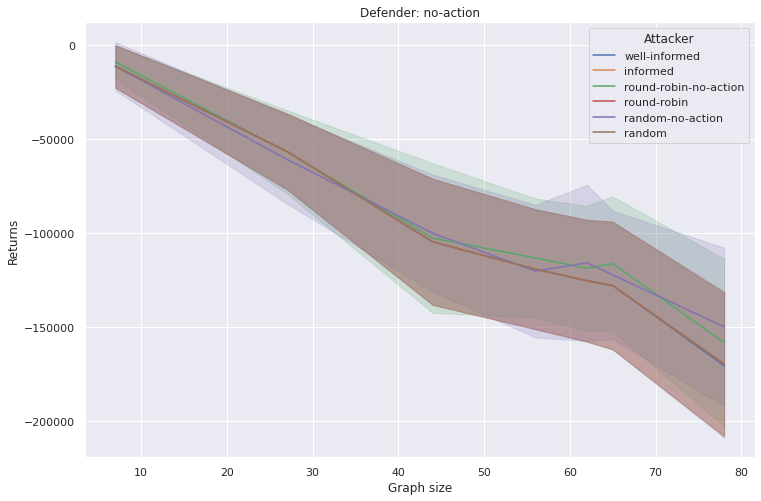

In [10]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper right")
g.set_title("Defender: no-action")

Text(0.5, 1.0, 'Defender: no-action')

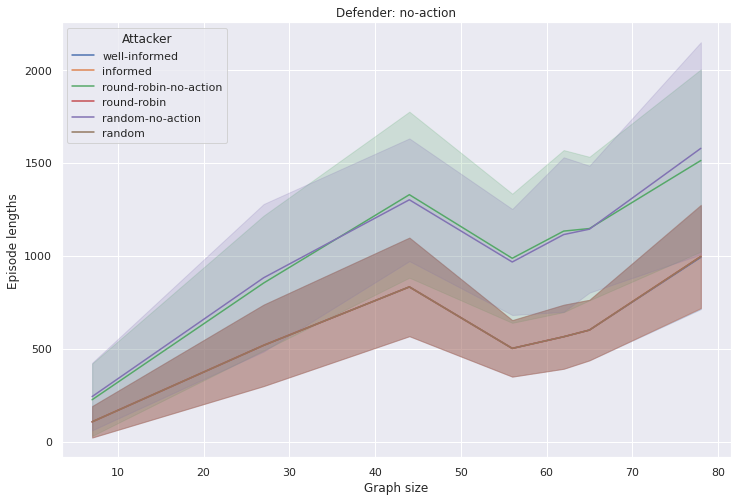

In [11]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper left")
g.set_title("Defender: no-action")

In [12]:
pd.set_option("display.max_columns", 32)
df.groupby("Attacker").describe()

Graph size                                               \
                           count       mean        std  min   25%   50%   75%   
Attacker                                                                        
informed                   350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
random                     350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
random-no-action           350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
round-robin                350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
round-robin-no-action      350.0  48.428571  22.665230  7.0  27.0  56.0  65.0   
well-informed              349.0  48.343840  22.642191  7.0  27.0  56.0  65.0   

                            Returns                                         \
                        max   count           mean           std       min   
Attacker                                                                     
informed               78.0   350.0 -102160.277143  56909.695503 -254282.0   
random                 78.0   350.0 -102160.277143  56909.695503 -254282.0   
random-no-action       78.0   350.0  -97239.028571  54123.508356 -249314.0   
round-robin            78.0   350.0 -102160.277143  56909.695503 -254282.0   
round-robin-no-action  78.0   350.0  -96480.102857  55632.290619 -272879.0   
well-informed          78.0   349.0 -102083.979943  56973.474471 -254282.0   

                                                           Episode lengths  \
                            25%       50%       75%    max           count   
Attacker                                                                     
informed              -142195.5 -106147.5 -63564.50    5.0           350.0   
random                -142195.5 -106147.5 -63564.50    5.0           350.0   
random-no-action      -133946.0  -97441.0 -63087.75  518.0           350.0   
round-robin           -142195.5 -106147.5 -63564.50    5.0           350.0   
round-robin-no-action -130762.0 -100245.0 -56860.25  401.0           350.0   
well-informed         -142353.0 -106088.0 -63531.00    5.0           349.0   

                                                                               \
                              mean         std   min     25%     50%      75%   
Attacker                                                                        
informed                588.391429  327.103426   8.0  388.25   568.5   784.50   
random                  588.391429  327.103426   8.0  388.25   568.5   784.50   
random-no-action       1032.042857  537.209692  21.0  694.00   994.0  1366.50   
round-robin             588.391429  327.103426   8.0  388.25   568.5   784.50   
round-robin-no-action  1026.142857  544.804554  15.0  682.25  1002.5  1311.25   
well-informed           586.633238  325.912675   8.0  388.00   563.0   783.00   

                               
                          max  
Attacker                       
informed               1831.0  
random                 1831.0  
random-no-action       3257.0  
round-robin            1831.0  
round-robin-no-action  2665.0  
well-informed          1831.0